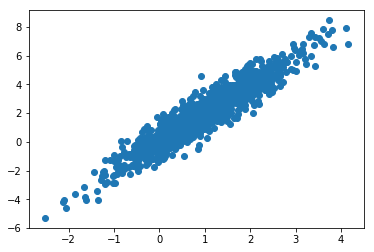

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Generate "real" data
X = np.random.normal(size=(1000, 2))
A = np.array([[1, 2], [-0.1, 0.5]])
b = np.array([1, 2])
X = np.dot(X,A) + b

# and stick them into an iterator
batch_size = 4

def iterate_minibatch(x, batch_size, shuffle=True):
    indices = np.arange(x.shape[0])
    if shuffle:
        np.random.shuffle(indices)
    
    for i in range(0, x.shape[0], batch_size):
        yield x[indices[i:i+batch_size], :]

plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [44]:
"""
Define the network
reference:
1. https://github.com/zackchase/mxnet-the-straight-dope/blob/master/P10-C01-gan-intro.ipynb
2. https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
3. https://github.com/pytorch/examples/tree/master/dcgan
"""

import torch
from torch.autograd import Variable
from torch import nn


class GAN(object):
    def __init__(self):
        
        # input, output
        #self.z = torch.FloatTensor(batch_size, 2)
        #self.x = torch.FloatTensor(batch_size, 2)
        
        # define the network
        self.netG = nn.Linear(2, 2)
        self.netD = nn.Sequential(
                        nn.Linear(2, 5), nn.Tanh(),
                        nn.Linear(5, 3), nn.Tanh(),
                        nn.Linear(3, 2))
        
        # define loss function
        #self.criterion = nn.BCELoss()
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x, z):
        self.z = Variable((torch.from_numpy(z)).float())
        self.fake_x = self.netG(self.z)
        self.real_x = Variable((torch.from_numpy(x)).float())
        
        self.label = Variable(torch.LongTensor(x.shape[0]).fill_(1), requires_grad=False)    # define null label with specific size
        
    def backward_D(self):
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        pred_fake = self.netD(self.fake_x.detach())    # stop backprop to the generator by detaching fake_B
        self.loss_D_fake = self.criterion(pred_fake, self.label*0)

        pred_real = self.netD(self.real_x)
        self.loss_D_real = self.criterion(pred_real, self.label*1)
        
        self.loss_D = self.loss_D_fake + self.loss_D_real
        
        self.loss_D.backward()
    
    def backward_G(self):
        # (2) Update G network: maximize log(D(G(z)))
        pred_fake = self.netD(self.fake_x)
        self.loss_G = self.criterion(pred_fake, self.label*1)    # fool the discriminator
        
        self.loss_G.backward()
    
    def test(self, x, z):
        z = Variable((torch.from_numpy(z)).float(), volatile=True)
        fake_x = self.netG(z)
        real_x = Variable((torch.from_numpy(x)).float(), volatile=True)
        
        pred_fake = self.netD(fake_x)
        pred_real = self.netD(real_x)
        
        return fake_x.data.numpy(), pred_real.data.numpy(), pred_fake.data.numpy()
        


discriminator loss at epoch 0: 0.856309

discriminator accuracy at epoch 0: 0.770000


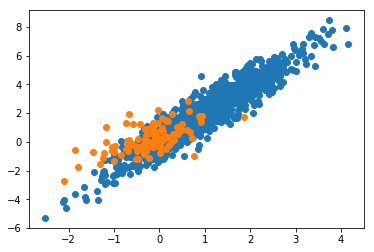


discriminator loss at epoch 1: 1.178026

discriminator accuracy at epoch 1: 0.660000


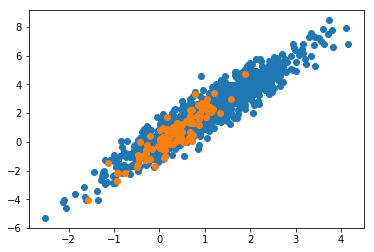


discriminator loss at epoch 2: 1.303094

discriminator accuracy at epoch 2: 0.570000


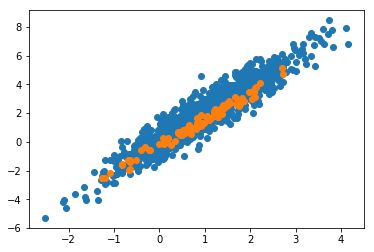


discriminator loss at epoch 3: 1.358155

discriminator accuracy at epoch 3: 0.500000


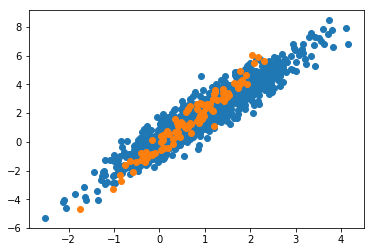


discriminator loss at epoch 4: 1.383267

discriminator accuracy at epoch 4: 0.525000


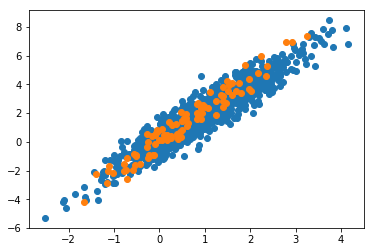


discriminator loss at epoch 5: 1.381137

discriminator accuracy at epoch 5: 0.545000


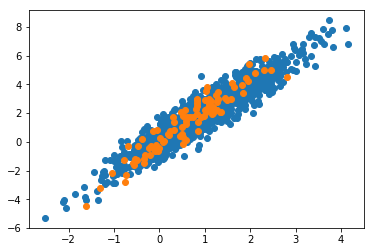


discriminator loss at epoch 6: 1.385448

discriminator accuracy at epoch 6: 0.450000


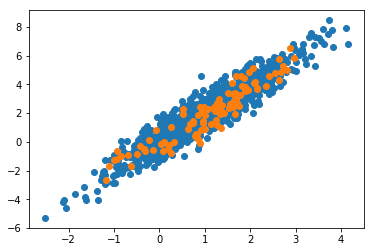


discriminator loss at epoch 7: 1.387559

discriminator accuracy at epoch 7: 0.500000


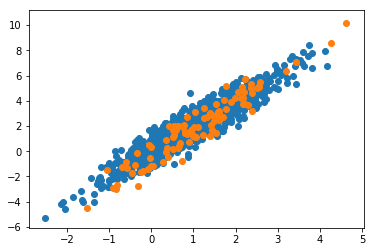


discriminator loss at epoch 8: 1.387765

discriminator accuracy at epoch 8: 0.490000


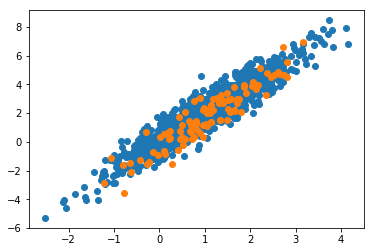


discriminator loss at epoch 9: 1.386309

discriminator accuracy at epoch 9: 0.500000


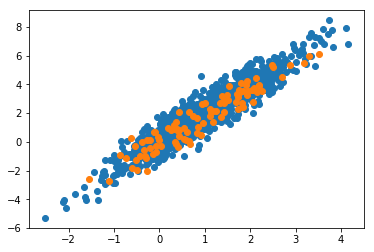

In [48]:
gan = GAN()
d_optim = torch.optim.Adam(gan.netD.parameters(), lr=0.05)
g_optim = torch.optim.Adam(gan.netG.parameters(), lr=0.01)

# initialize weights in the model
def init_weights(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 0.02)

gan.netD.apply(init_weights)
gan.netG.apply(init_weights)

# Training loop
for epoch in range(10):
    avg_loss = 0.
    count = 0
    for x_batch in iterate_minibatch(X, batch_size=batch_size):
            
        # generate noise z
        z_batch = np.random.normal(size=(4, 2))
        
        # forward
        gan.forward(x_batch, z_batch)
            
        # update D network
        d_optim.zero_grad()
        gan.backward_D()
        d_optim.step()
        
        # update G network
        g_optim.zero_grad()
        gan.backward_G()
        g_optim.step()
            
        avg_loss += gan.loss_D.data.numpy()
        count += 1
            
    avg_loss /= count
    z = np.random.normal(size=(100, 2))
    excerpt = np.random.randint(1000, size=100)   
    fake_x, pred_real, pred_fake = gan.test(X[excerpt,:], z)
    
    accuracy = 0.5 * (np.sum(pred_real[:,1]>pred_real[:,0]) / 100. 
                      + np.sum(pred_fake[:,0]>pred_fake[:,1]) / 100.)
    print('\ndiscriminator loss at epoch %d: %f' % (epoch, avg_loss))
    print('\ndiscriminator accuracy at epoch %d: %f' % (epoch, accuracy))
    plt.scatter(X[:, 0], X[:, 1])
    plt.scatter(fake_x[:, 0], fake_x[:, 1])
    plt.show()